<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/t5/T5ForSequenceClassification_custom_mlflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MLFLOW
https://mlflow.org/docs/latest/introduction/index.html


MLflow is a solution to many of these issues in this dynamic landscape, offering tools and simplifying processes to streamline the ML lifecycle and foster collaboration among ML practitioners.

https://mlflow.org/docs/latest/llms/llm-evaluate/index.html

# MLflow transformers Guide
https://mlflow.org/docs/latest/llms/transformers/guide/index.html
https://mlflow.org/docs/latest/llms/transformers/tutorials/fine-tuning/transformers-fine-tuning.html


# Model
https://huggingface.co/google-t5/t5-base#uses
https://huggingface.co/docs/transformers/en/tasks/sequence_classification

The task illustrated in this tutorial is supported by the following model architectures:
ALBERT, BART, BERT, BigBird, BigBird-Pegasus, BioGpt, BLOOM, CamemBERT, CANINE, CodeLlama, ConvBERT, CTRL, Data2VecText, DeBERTa, DeBERTa-v2, DistilBERT, ELECTRA, ERNIE, ErnieM, ESM, Falcon, FlauBERT, FNet, Funnel Transformer, Gemma, GPT-Sw3, OpenAI GPT-2, GPTBigCode, GPT Neo, GPT NeoX, GPT-J, I-BERT, Jamba, LayoutLM, LayoutLMv2, LayoutLMv3, LED, LiLT, LLaMA, Longformer, LUKE, MarkupLM, mBART, MEGA, Megatron-BERT, Mistral, Mixtral, MobileBERT, MPNet, MPT, MRA, MT5, MVP, Nezha, Nyströmformer, OpenLlama, OpenAI GPT, OPT, Perceiver, Persimmon, Phi, PLBart, QDQBert, Qwen2, Qwen2MoE, Reformer, RemBERT, RoBERTa, RoBERTa-PreLayerNorm, RoCBert, RoFormer, SqueezeBERT, StableLm, Starcoder2, T5, TAPAS, Transformer-XL, UMT5, XLM, XLM-RoBERTa, XLM-RoBERTa-XL, XLNet, X-MOD, YOSO


# ngrok
Connect localhost to the internet for testing applications and APIs
Bring secure connectivity to apps and APIs in localhost and dev/test environments with just one command or function call.
- Webhook testing
- Developer Previews
- Mobile backend testing

https://ngrok.com/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mlflow pyngrok evaluate  bitsandbytes accelerate datasets transformers==4.39.3 --quiet
get_ipython().system_raw("mlflow ui --port 5000 &")

In [3]:

from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

In [4]:
from google.colab import userdata
NGROK_AUTH_TOKEN  = userdata.get('NGROK')

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://ae40-34-125-187-188.ngrok-free.app


In [5]:
# Disable tokenizers warnings when constructing pipelines
%env TOKENIZERS_PARALLELISM=false

import warnings

# Disable a few less-than-useful UserWarnings from setuptools and pydantic
warnings.filterwarnings("ignore", category=UserWarning)

env: TOKENIZERS_PARALLELISM=false


### Preparing the Dataset and Environment for Fine-Tuning

#### Key Steps in this Section

1. **Loading the Dataset**: Utilizing the `sms_spam` dataset for spam detection.
2. **Splitting the Dataset**: Dividing the dataset into training and test sets with an 80/20 distribution.
3. **Importing Necessary Libraries**: Including libraries like `evaluate`, `mlflow`, `numpy`, and essential components from the `transformers` library.

Before diving into the fine-tuning process, setting up our environment and preparing the dataset is crucial. This step involves loading the dataset, splitting it into training and testing sets, and initializing essential components of the Transformers library. These preparatory steps lay the groundwork for an efficient fine-tuning process.

This setup ensures that we have a solid foundation for fine-tuning our model, with all the necessary data and tools at our disposal. In the following Python code, we'll execute these steps to kickstart our model fine-tuning journey.

In [8]:
import evaluate
import numpy as np
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    pipeline,
)

import mlflow
import pandas as pd


In [9]:
data_path = "/content/drive/MyDrive/data/documents_final_cv.csv"
data = pd.read_csv(data_path, header=None)
data_path_test = "/content/drive/MyDrive/data/documents_test_cv.csv"
data_test= pd.read_csv(data_path_test,  header=None)
data.columns = ["label", "text"]
data_test.columns = ["label", "text"]

In [10]:
label_dic = {"cv": 1, "non-cv": 0}

In [11]:
data['label'] = data['label'].map(label_dic)
data_test['label'] = data_test['label'].map(label_dic)

In [12]:
df_train_test = Dataset.from_pandas(data)
df_val = Dataset.from_pandas(data_test)
df_train_test = df_train_test.train_test_split(test_size=0.2)

In [13]:
train_dataset = df_train_test["train"]
test_dataset = df_train_test["test"]

In [14]:
train_dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 160
})

In [15]:
test_dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 40
})

In [16]:
train_dataset[0]['text']

'evaluation document created 03241 sloan yvor record duane lorem ipsum dolor sit consectetuer adipiscing proin praesent'

In [17]:
train_dataset[0]['label']

0

### Tokenization and Dataset Preparation

In the next code block, we tokenize our text data, preparing it for the fine-tuning process of our model.
    
With our dataset loaded and split, the next step is to prepare our text data for the model. This involves tokenizing the text, a crucial process in NLP where text is converted into a format that's understandable and usable by our model.

#### Tokenization Process

- **Loading the Tokenizer**: Using the `AutoTokenizer` from the `transformers` library for the `distilbert-base-uncased` model's tokenizer.
- **Defining the Tokenization Function**: Creating a function to tokenize text data, including padding and truncation.
- **Applying Tokenization to the Dataset**: Processing both the training and testing sets for model readiness.

Tokenization is a critical step in preparing text data for NLP tasks. It ensures that the data is in a format that the model can process, and by handling aspects like padding and truncation, it ensures consistency across our dataset, which is vital for training stability and model performance.

In [18]:
PROJECT = "FlanT5-Custom"
MODEL_NAME = 'google-t5/t5-base'
DATASET = "CVS-Premcloud"

In [19]:
MODEL_ID = "google-t5/t5-base"
# Load tokenizer of FLAN-t5
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, model_max_length=512)


In [20]:
def tokenize_function(examples):
    # Pad/truncate each text to 512 tokens. Enforcing the same shape
    # could make the training faster.
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )


seed = 22

# Tokenize the train and test datasets
train_tokenized = train_dataset.map(tokenize_function)
train_tokenized = train_tokenized.remove_columns(["text"]).shuffle(seed=seed)

test_tokenized = test_dataset.map(tokenize_function)
test_tokenized = test_tokenized.remove_columns(["text"]).shuffle(seed=seed)

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

# Model Loader with a sequence classification head
https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification

https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSequenceClassification

In [21]:
# Set the mapping between int label and its meaning.
id2label = {0: "non-cv", 1: "cv"}
label2id = {"non-cv": 0, "cv": 1}

# Acquire the model from the Hugging Face Hub, providing label and id mappings so that both we and the model can 'speak' the same language.
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    label2id=label2id,
    id2label=id2label,
)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google-t5/t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from transformers import DataCollatorWithPadding, DataCollatorForSeq2Seq
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
data_collator = DataCollatorWithPadding(tokenizer=tokenizer ,  pad_to_multiple_of=8)



In [23]:
REPOSITORY_ID = f"{MODEL_ID.split('/')[1]}-text-classification"
REPOSITORY_ID

't5-base-text-classification'

## Compute metrics
### EvalPrediction
https://huggingface.co/docs/transformers/en/internal/trainer_utils
https://discuss.huggingface.co/t/trainer-class-compute-metrics-and-evalprediction/1698

https://github.com/huggingface/transformers/blob/main/src/transformers/trainer_utils.py

In [24]:

def compute_metrics(eval_preds):
    # load metrics
    metric = evaluate.load("f1")
    metric1 = evaluate.load("roc_auc")
    metric2 = evaluate.load("recall")
    metric3 = evaluate.load("precision")


    logits, labels = eval_preds
    if isinstance(logits, tuple):
        logits = logits[0]
    predictions = np.argmax(logits, axis=-1)

    result = {}
    result['f1'] = metric.compute(predictions=predictions, references=labels, average='macro')['f1']
    result['roc_auc'] = metric1.compute(prediction_scores=predictions, references=labels, average='macro')['roc_auc']
    result['recall'] = metric2.compute(predictions=predictions, references=labels, average='macro')['recall']
    result['precision'] = metric3.compute(predictions=predictions, references=labels, average='macro')['precision']

    return result

In [25]:
# Checkpoints will be output to this `training_output_dir`.
training_output_dir = "/tmp/sms_trainer"
training_args = TrainingArguments(
    output_dir=training_output_dir,
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-3,
    weight_decay=0.01,
    logging_steps=8,
    num_train_epochs=4,
    load_best_model_at_end=True,
    save_strategy="epoch",
    metric_for_best_model='eval_loss',
    greater_is_better=False,

)

# Instantiate a `Trainer` instance that will be used to initiate a training run.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [26]:
# If you are running this tutorial in local mode, leave the next line commented out.
# Otherwise, uncomment the following line and set your tracking uri to your local or remote tracking server.

mlflow.set_tracking_uri("http://127.0.0.1:5000")

### Integrating MLflow for Experiment Tracking

The final preparatory step before beginning the training process is to integrate MLflow for experiment tracking.
   
MLflow is a critical tool in our workflow, enabling us to log, monitor, and compare different runs of our model training.

#### Setting up the MLflow Experiment

- **Naming the Experiment**: We use `mlflow.set_experiment` to create a new experiment or assign the current run to an existing experiment. In this case, we name our experiment "Spam Classifier Training". This name should be descriptive and related to the task at hand, aiding in organizing and identifying experiments later.
- **Role of MLflow in Training**: By setting up an MLflow experiment, we can track various aspects of our model training, such as parameters, metrics, and outputs. This tracking is invaluable for comparing different models, tuning hyperparameters, and maintaining a record of our experiments.

#### Benefits of Experiment Tracking
Utilizing MLflow for experiment tracking offers several advantages:

- **Organization**: Keeps your training runs organized and easily accessible.
- **Comparability**: Allows for easy comparison of different training runs to understand the impact of changes in parameters or data.
- **Reproducibility**: Enhances the reproducibility of experiments by logging all necessary details.

With MLflow set up, we're now ready to begin the training process, keeping track of every important aspect along the way.

In the next code snippet, we'll set up our MLflow experiment for tracking the training of our spam classification model.

In [27]:
# Pick a name that you like and reflects the nature of the runs that you will be recording to the experiment.
mlflow.set_experiment("T5 Custom Classifier Training")

<Experiment: artifact_location='mlflow-artifacts:/201719104341236608', creation_time=1714574077834, experiment_id='201719104341236608', last_update_time=1714574077834, lifecycle_stage='active', name='T5 Custom Classifier Training', tags={}>

### Starting the Training Process with MLflow

In this step, we initiate the fine-tuning training run, utilizing the native auto-logging functionality to record the parameters used and loss metrics calculated during the training process.
    
With our model, training arguments, and MLflow experiment set up, we are now ready to start the actual training process. This step involves initiating an MLflow run, which will encapsulate all the training activities and metrics.

#### Initiating the MLflow Run

- **Starting an MLflow Run**: We use `mlflow.start_run()` to begin a new MLflow run. This function creates a new run context, under which all the training operations and logging will occur.
- **Training the Model**: Inside the MLflow run context, we call `trainer.train()` to start training our model. This function will run the training loop, processing the data in batches, updating model parameters, and evaluating the model.

#### Monitoring the Training Progress
During training, the `Trainer` object will output logs that provide valuable insights into the training progress:

- **Loss**: Indicates the model's performance, with lower values signifying better performance.
- **Learning Rate**: Shows the current learning rate used during training.
- **Epoch Progress**: Displays the progress through the current epoch.

These logs are crucial for monitoring the model's learning process and making any necessary adjustments. By tracking these metrics within an MLflow run, we can maintain a comprehensive record of the training process, enhancing reproducibility and analysis.

In the next code block, we will start our MLflow run and begin training our model, closely observing the output to gauge the training progress.

In [28]:
!rm -rf ./flan-T5-fine-tune

In [29]:
!mkdir ./flan-T5-fine-tune
custom_path = "./flan-T5-fine-tune/"

In [31]:
with mlflow.start_run() as run:
    train_results = trainer.train()
    print(train_results.metrics)
    trainer.model.save_pretrained(custom_path)
    trainer.data_collator.tokenizer.save_pretrained(custom_path)

    transformers_model = {"model": trainer.model, "tokenizer": trainer.data_collator.tokenizer}
    task = "text-classification"
    model_info = mlflow.transformers.log_model(
        transformers_model=transformers_model,
        artifact_path="text_classifier",
        task=task,
    )
    print(model_info.metadata)


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Recall,Precision
1,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
2,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
4,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
5,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
6,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
7,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
8,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
9,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
10,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight', 'transformer.decoder.embed_tokens.weight'].


{'train_runtime': 202.4371, 'train_samples_per_second': 7.904, 'train_steps_per_second': 0.988, 'total_flos': 977243062272000.0, 'train_loss': 5.304024398355978e-07, 'epoch': 10.0}


2024/05/01 16:00:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.2.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/01 16:00:46 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.17.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.17.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/01 16:00:53 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.4.26+cuda12.cudnn89) contains a local version label (+cuda12.cudnn89). MLflow logged a pip requirement for this package as 'jaxlib==0.4.26' without t

In [32]:
run.to_dictionary()

{'info': {'artifact_uri': 'mlflow-artifacts:/201719104341236608/d6b5caecc8d24e1aa61e4ead5ebc9fc4/artifacts',
  'end_time': None,
  'experiment_id': '201719104341236608',
  'lifecycle_stage': 'active',
  'run_id': 'd6b5caecc8d24e1aa61e4ead5ebc9fc4',
  'run_name': 'hilarious-gnat-333',
  'run_uuid': 'd6b5caecc8d24e1aa61e4ead5ebc9fc4',
  'start_time': 1714579034455,
  'status': 'RUNNING',
  'user_id': 'root'},
 'data': {'metrics': {},
  'params': {},
  'tags': {'mlflow.user': 'root',
   'mlflow.source.name': '/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py',
   'mlflow.source.type': 'LOCAL',
   'mlflow.runName': 'hilarious-gnat-333'}}}

In [33]:
run.data

<RunData: metrics={}, params={}, tags={'mlflow.runName': 'hilarious-gnat-333',
 'mlflow.source.name': '/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'root'}>

In [34]:
import transformers
from mlflow.models import infer_signature
from mlflow.transformers import generate_signature_output
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [35]:
classification_components = mlflow.transformers.load_model(
    model_info.model_uri, return_type="components"
)


2024/05/01 16:00:59 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/01 16:01:10 INFO mlflow.transformers: 'runs:/d6b5caecc8d24e1aa61e4ead5ebc9fc4/text_classifier' resolved as 'mlflow-artifacts:/201719104341236608/d6b5caecc8d24e1aa61e4ead5ebc9fc4/artifacts/text_classifier'


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Loading and Testing the Model from MLflow

After logging our fine-tuned model to MLflow, we'll now load and test it.
    
#### Loading the Model from MLflow

- **Using mlflow.transformers.load_model**: We use this function to load the model stored in MLflow. This demonstrates how models can be retrieved and utilized post-training, ensuring they are accessible for future use.
- **Retrieving Model URI**: We use the `model_uri` obtained from logging the model to MLflow. This URI is the unique identifier for our logged model, allowing us to retrieve it accurately.

#### Testing the Model with Validation Text

- **Preparing Validation Text**: We use a creatively crafted text to test the model's performance. This text is designed to mimic a typical spam message, which is relevant to our model's training on spam classification.
- **Evaluating Model Output**: By passing this text through the loaded model, we can observe its performance and effectiveness in a practical scenario. This step is crucial to ensure that the model works as expected in real-world conditions.

Testing the model after loading it from MLflow is essential for several reasons:

- **Validation of Logging Process**: It confirms that the model was logged and loaded correctly.
- **Practical Performance Assessment**: Provides a real-world assessment of the model's performance, which is critical for deployment decisions.
- **Demonstrating End-to-End Workflow**: Showcases a complete workflow from training, logging, loading, to using the model, which is vital for understanding the entire model lifecycle.

In the next code block, we'll load our model from MLflow and test it with a validation text to assess its real-world performance.

In [81]:
def load_dataset_test(data_path) -> Dataset:
    """ Load dataset. """
    dataset_ecommerce_pandas = pd.read_csv(data_path, header=None, names=['label', 'text'])
    dataset_ecommerce_pandas['label'] = dataset_ecommerce_pandas['label'].astype(str)
    dataset_ecommerce_pandas['label'] = dataset_ecommerce_pandas['label'].map(label_dic)
    dataset_ecommerce_pandas['text'] = dataset_ecommerce_pandas['text'].astype(str)
    dataset = Dataset.from_pandas(dataset_ecommerce_pandas)

    return dataset

In [82]:
datatest= load_dataset_test(data_path_test)

In [83]:
len(datatest)

284

In [84]:
datatest[0]

{'label': 1,
 'text': 'justin wa adkins thrives cultivating business workflows creating strategic key stakeholders simple effective delights customers key inflection points inside business focusing innovation bringing 8 years coding experience managing mission world better place supporting make central actuarial science may manager 2021 construction accounting consulting telecom erp related project data conversion ms dynamics solomon vista 3 months limited solomon cio role managing multiple systems bringing cohesion lead senior analyst 2016 april systems construction accounting battle erp related project project code vista etl modules reconcile jc beginning balances using managed implemented ms materials module batch creation multiple streamlined xml certified payroll report efficient washington equipment gps import allocation procedure built forecast software project managers upload capabilities directly viewpoint database lead eos level 10 weekly meetings mentored 6 various business 

In [85]:
import torch
from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import classification_report

In [86]:
model = classification_components.get('model')
tokenizer = classification_components.get('tokenizer')

In [58]:
reconstructed_pipeline = transformers.pipeline(**classification_components)

In [49]:
reconstructed_pipeline("this is a text")

[{'label': 'non-cv', 'score': 0.9999966621398926}]

In [68]:
def classify(text_to_classify: str) -> str:
    """Classify a text using the model."""
    inputs = tokenizer.encode_plus(text_to_classify, padding='max_length', max_length=512, return_tensors='pt')
    inputs = inputs.to('cuda') if torch.cuda.is_available() else inputs.to('cpu')
    outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=5)

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return prediction


def evaluate_model() -> None:
    """Evaluate the model on the test dataset."""
    predictions_list, labels_list, scores = [], [], []

    samples_number = len(datatest)
    progress_bar = tqdm(range(samples_number))

    for i in range(samples_number):
        text = datatest['text'][i]
        pred_dict= reconstructed_pipeline(text)
        pred = pred_dict[0].get("label")
        pred = 1 if pred == "cv" else 0
        predictions_list.append(pred)
        scores.append(pred_dict[0].get("score"))
        labels_list.append(int(datatest['label'][i]))

        progress_bar.update(1)

    report = classification_report(labels_list, predictions_list)
    print(report)
    return predictions_list, labels_list, scores

In [69]:
predictions_list, labels_list, scores = evaluate_model()

  0%|          | 0/284 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       142
           1       1.00      0.99      1.00       142

    accuracy                           1.00       284
   macro avg       1.00      1.00      1.00       284
weighted avg       1.00      1.00      1.00       284



In [66]:
from sklearn import metrics

In [70]:
confusion_matrix = metrics.confusion_matrix(labels_list, predictions_list)

In [72]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["non-cv", "cv"])

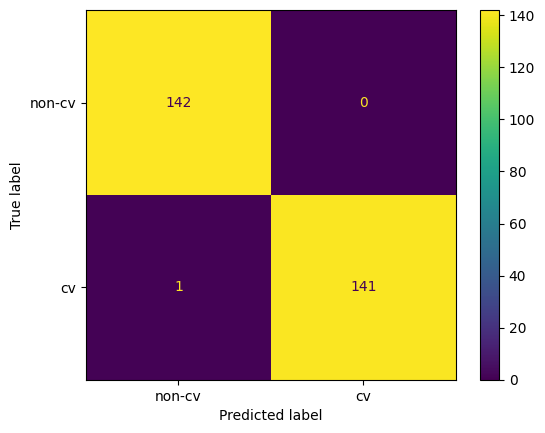

In [74]:
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

In [87]:
ngrok.kill()